# Customer Satisfaction

#### Note
##### You are now on Google Colab, here you will be able to interact with each cell, run and tinker with the code, all on your browser.
**Note :**
* **You will be able to run the code only after signing into colab with your Google account.**
* **If the graphs do not show up or have loaded incorrectly, click `Runtime` in the tool bar and select `Run all`.**<br>
* **Since the notebook isn't authored by Google, a warning will show up citing the same.**<br>
* **Running the program is absolutely safe. Therefore, you can click `Run Anyway`.**


# Introduction

Customer satisfaction is defined as a measurement that determines how happy customers are with a company’s products, services, and capabilities. Customer satisfaction information, including surveys and ratings, can help a company determine how to best improve or changes its products and services. An organization’s main focus must be to satisfy its customers. This applies to industrial firms, retail and wholesale businesses, government bodies, service companies, nonprofit organizations, and every subgroup within an organization [1].

Satisfaction is a major outcome of marketing activity and serves to **link processes culminating in purchase and consumption** with postpurchase phenomena such as **attitude change, repeat purchase, and brand loyalty**. The centrality of the concept is reflected by its inclusion in the marketing concept that profits are generated through the satisfaction of consumer needs and wants [2].



It can be very valuable for a corporation to flag a potential dissatisfied customer in early stages of engagement, to then course correct and improve customer happiness. To this end, this project explores the viability of developing a machine learning model that can predict customer satisfaction with high accuracy.



## Project Outline

### 1. Scope of the project:

* To build a supervised learning classification model that can predict customer dissatisfaction with atleast 90% accuracy (true positive rate) on validation data.
* To gauge several evaluation metrics for the predictive model and determine their suitability for application in customer satisfaction prediction. 
* To extract high impact predictors of customer satisfaction via model interpretation.
* To identify any potential for further improvement and scope for practical application of such models.

### 2. Data:

For this project, we will be using data provided by **Santander Bank**. The bank has provided information collected throughout the customer journey and the associated end of journey outcome of customer satisfaction. Furthermore, a key challenge comes from the fact that the bank has **anonymized the features** provided, rendering feature interpretation impossible. 

However, it is still possible to identify high impact predictors which will be of great use for the Santander Bank.

*Note: The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers.*

### 3. Approach:

* After the routine data cleanup and eda, we will check for class imbalances in the dataset. As we are working with customer satisfaction data, we expect there to be a natural imbalance, with satisfied customers being the majority, in the collected data as Santander Bank is a reasonably prominent bank which employs around 10,000 people with a principal market in the northeastern United States.  

* If there are imbalances in the data, we will employ resampling techniques to either generate synthetic data or perform simple up/down sampling techniques to generate new data and hence create a balanced training dataset.

* As the primary focus is to build a predictive model, we will then proceed to create various base models and identify which modeling approach works. We will use this understanding to then create ensemble models to reduce generalization error.

* Finally, we can compare these models and identify suitable metrics to best evaluate our model predictions. 

* After identifying an optimal model suitable for our application, we can then see which predictors have the most impact on model performance using techniques such as permutation importance.

* Finally, we will make an assessment of the wins and the shortcomings of our modelling and arrive at potential avenues for improvement.




## Let's get the project started!

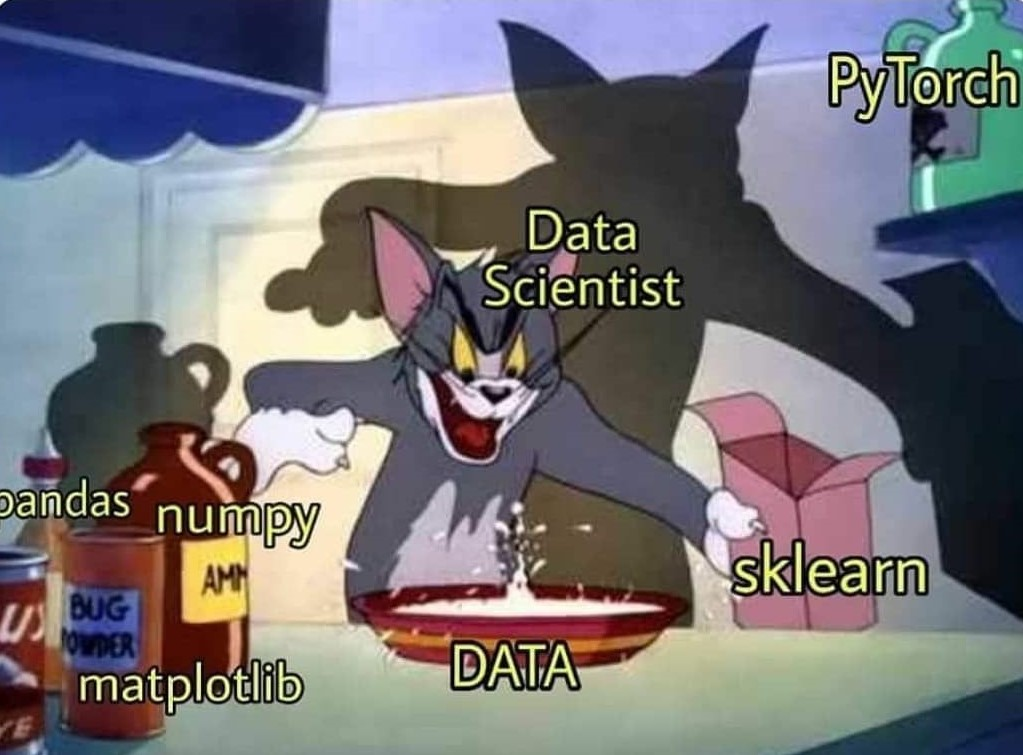

In [ ]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance

from scipy import stats

from prettytable import PrettyTable

from collections import Counter

import warnings

sns.set()

## Loading data

In [ ]:
#get dataset as zip files from github repo
import requests, zipfile, io
r = requests.get("https://github.com/ojask12/Fault-Detection-using-Hadoop/blob/main/santander-customer-satisfaction.zip?raw=true")

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#reading train and test data into respective dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.describe() #gets summary statistics on all our features

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

There are 371 features in our dataset. The code above provides summary statistics to get a sense of our dataset. 
1. We can observe that the features are of varying scales
2. Some columns have extreme values (eg, -999999) present which could skew our model. 

# Data Cleaning

### 1. Checking for nan values in our datasets

In [ ]:
print("Count of columns with missing values in the train data: {}".format(len(df_train.columns[df_train.isna().sum() > 0])))

Count of columns with missing values in the train data: 0


In [ ]:
print("Count of columns with missing values in the test data: {}".format(len(df_test.columns[df_test.isna().sum() > 0])))

Count of columns with missing values in the test data: 0


### 2. Checking for non-numeric columns 

In [ ]:
print("Count of columns with non-numerical values in the train data: {}".format(len(df_train.columns[(df_train.dtypes != int) & (df_train.dtypes != float)])))

Count of columns with non-numerical values in the train data: 0


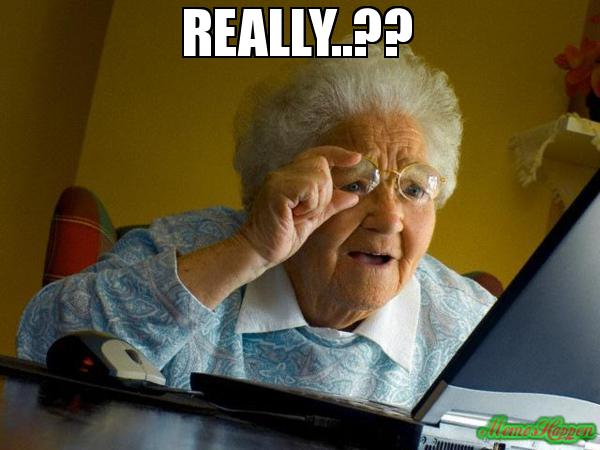

It can be inferred that the data is very thoroughly collected/cleaned preventing any occurence of missing values. Furthermore, there aren't any categorical features that requires encoded, as the design matrix consists features of either int or float data types.

In [ ]:
def handle_extreme_vals(data):
    df = data.copy()
    for col in df.columns:
      df[col] = df[col].replace(-999999, 0)
      df[col] = df[col].replace(9999999999, 0)
    
    return df

In [ ]:
df_train = handle_extreme_vals(df_train)
df_test = handle_extreme_vals(df_test)

The number of predictor variables in our design matrix so far, still remains considerably high. So our next step would naturally be to try and remove features that do not add value, or conversely select important features with high predictive power, to our model by applying selection procedures.

### Optimizing design matrix by removing select predictors

In [ ]:
response = "TARGET"

predictors = list(df_test.columns)

In [ ]:
#features that have only 1 unique value 

var_threshold = 0
low_var_predictors = []

for col in predictors:
    if df_train[col].var() <= var_threshold:
        low_var_predictors.append(col)
        
print("We are considering any variable with variance 0 which essentially means that the entire column has only one unique value and hence not a random variable.\n\nNumber of predictors with zero variance =", len(low_var_predictors))

We are considering any variable with variance 0 which essentially means that the entire column has only one unique value and hence not a random variable.

Number of predictors with zero variance = 44


In [ ]:
#duplicate or identical features

df_T = df_train.T
df_T = pd.DataFrame(df_T)
duplicated_predictors = df_T.duplicated()
duplicated_predictors = list(df_train.columns[list(duplicated_predictors)])

print("Number of predictors with duplicacy =", len(duplicated_predictors))

Number of predictors with duplicacy = 68


In [ ]:
#highly correlated features

cor_threshold = 0.95
matrix = df_train.corr().abs()

selected = matrix.where(np.triu(np.ones(matrix.shape),k=1).astype(np.bool)) 
correlated_predictors = [i for i in selected.columns if any(selected[i] >= cor_threshold)]

print("In this case, we are checking for variables which may not be totally identical, but are still highly correlated, and can be removed to reduce the dimension of our design matrix.")
print("Number of higly correlated predictors =", len(correlated_predictors))

In this case, we are checking for variables which may not be totally identical, but are still highly correlated, and can be removed to reduce the dimension of our design matrix.
Number of higly correlated predictors = 118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
to_be_dropped = [
    "ID", #it is an unique value for every entry in the data
]

to_be_dropped = to_be_dropped + low_var_predictors + duplicated_predictors + correlated_predictors

final_drop = []

#dropping all columns identified above
for col in to_be_dropped:
    if (col not in final_drop) and (col != response):
        final_drop.append(col)

def dropping_cols(df, cols=final_drop):
    df = df.drop(cols, axis=1)
    return df

df_train = dropping_cols(df_train)
df_test = dropping_cols(df_test)

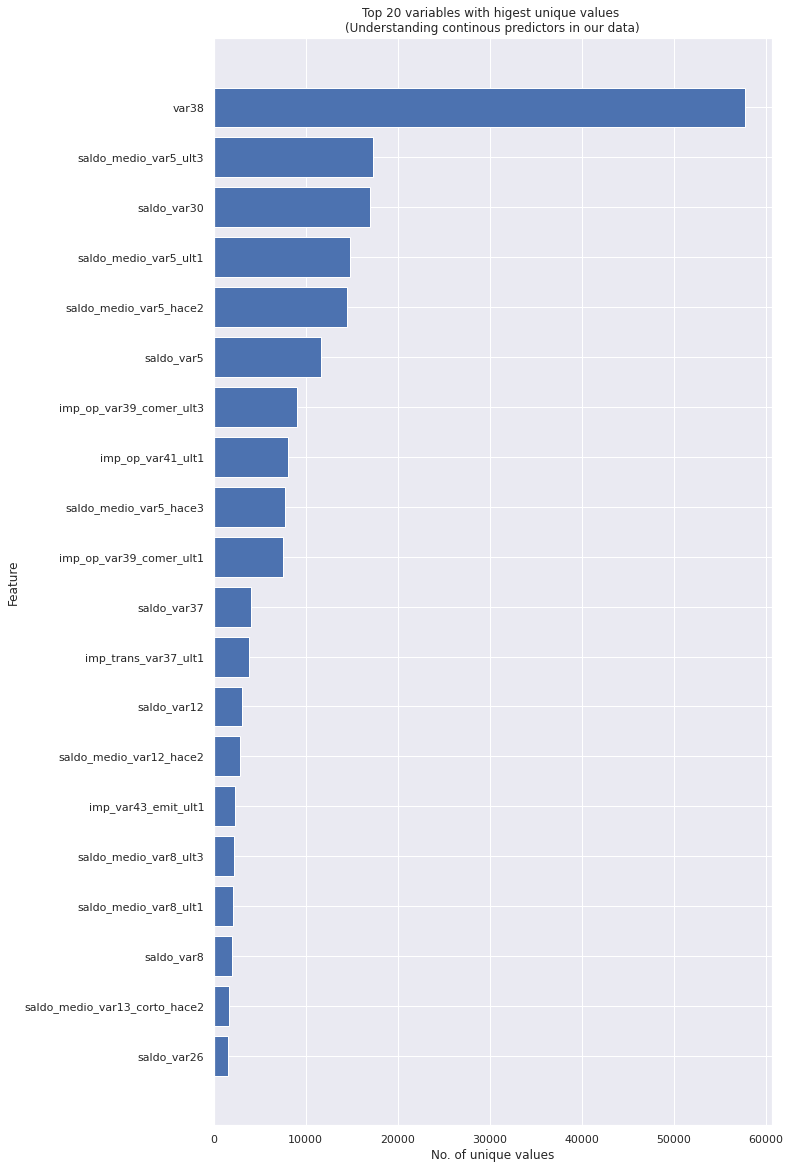

In [ ]:
#identifying columns that have the highest number of unique values to get a sense of continous variables in our data
top=20
plot_data = pd.DataFrame(df_train.nunique().sort_values(ascending=False)).reset_index().head(top)

plt.figure(figsize=(10,20))
plt.barh(plot_data['index'][::-1], plot_data[0][::-1])
plt.title(f"Top {top} variables with higest unique values \n(Understanding continous predictors in our data)")
plt.ylabel("Feature")
plt.xlabel("No. of unique values")
plt.show()

### Change in Shape of data after preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


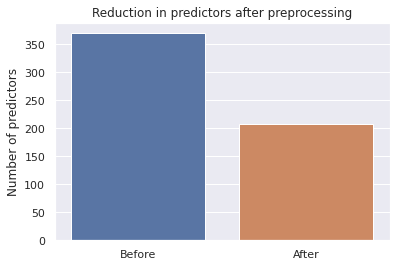

We have removed 162 features from the original data, leaving us with 208 predictors after preprocessing.


In [ ]:
ax = sns.barplot(["Before", "After"], [len(predictors), len(df_train.columns)])
ax.set(ylabel='Number of predictors', title='Reduction in predictors after preprocessing')
plt.show()
print(f'We have removed {len(predictors) - len(df_train.columns)} features from the original data, leaving us with {len(df_train.columns)} predictors after preprocessing.')

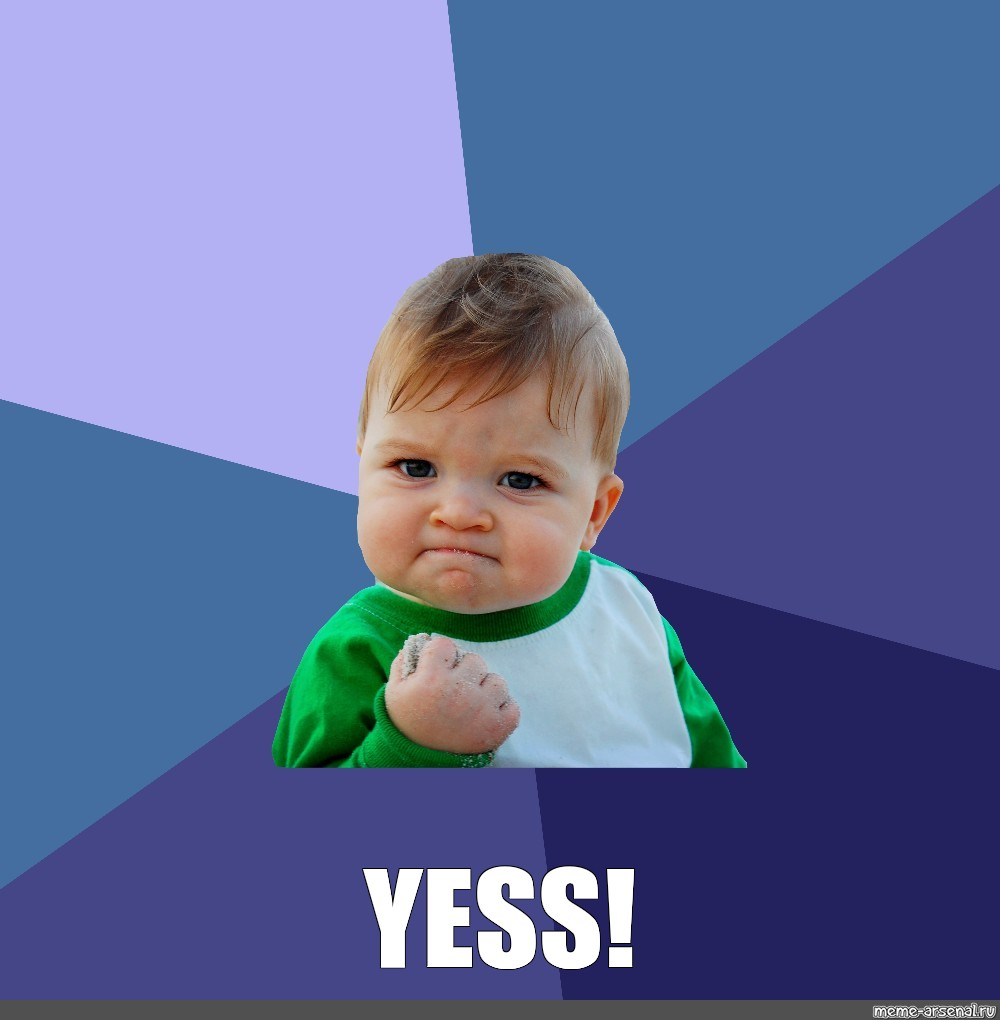

# Exploratory Data Analysis

The number of predictors have now significantly come down, yet it is still quite high, making it unfeasible to perform a visual analysis for each feature.

Also, as all the variables are anonymized, their meaning can't be identified by their names. 

That said, let's try to get a better sense of our data and if possible understand a few important features.

In [ ]:
#checking if any categorical-like variables exist in our data 
print("Count of variables with just two unique values is", len(df_train.columns[df_train.nunique() == 2]))

Count of variables with just two unique values is 56


In [ ]:
cols_2_num = len(df_train.columns[df_train.nunique() == 2])
cols_2 = df_train.columns[df_train.nunique() == 2]
x_cols2 = df_train[cols_2] 

for i in x_cols2.columns:
  print(i,x_cols2[i].unique())

ind_var1_0 [0 1]
ind_var1 [0 1]
ind_var5_0 [1 0]
ind_var5 [0 1]
ind_var6_0 [0 1]
ind_var6 [0 1]
ind_var8_0 [0 1]
ind_var8 [0 1]
ind_var12_0 [0 1]
ind_var12 [0 1]
ind_var13_0 [0 1]
ind_var13_corto_0 [0 1]
ind_var13_largo_0 [0 1]
ind_var13_medio_0 [0 1]
ind_var14_0 [0 1]
ind_var14 [0 1]
ind_var17_0 [0 1]
ind_var17 [0 1]
ind_var18_0 [0 1]
ind_var19 [0 1]
ind_var20_0 [0 1]
ind_var20 [0 1]
ind_var24_0 [0 1]
ind_var24 [0 1]
ind_var25_cte [0 1]
ind_var26_0 [0 1]
ind_var30_0 [1 0]
ind_var30 [0 1]
ind_var31_0 [0 1]
ind_var31 [0 1]
ind_var32_cte [0 1]
ind_var32_0 [0 1]
ind_var33_0 [0 1]
ind_var33 [0 1]
ind_var34_0 [0 1]
ind_var37_cte [0 1]
ind_var37_0 [0 1]
ind_var39_0 [1 0]
ind_var44_0 [0 1]
ind_var44 [0 1]
delta_imp_reemb_var17_1y3 [ 0 -1]
delta_imp_trasp_var17_in_1y3 [ 0 -1]
delta_imp_trasp_var33_in_1y3 [ 0 -1]
imp_reemb_var33_ult1 [   0 1200]
imp_trasp_var33_out_ult1 [   0 3000]
ind_var7_emit_ult1 [0 1]
ind_var7_recib_ult1 [0 1]
ind_var10_ult1 [0 1]
ind_var10cte_ult1 [0 1]
ind_var43_emit_ult

It can be observed in the data is that certain variables in our dataset have only 2 unique values (most of them, 0 and 1), which suggests that perhaps these anonymized variables were originally categorical and were later binary encoded.

In [ ]:
print("Count of variables with just three or four unique values is", len(df_train.columns[(df_train.nunique() == 3) | (df_train.nunique() == 4)]))

Count of variables with just three or four unique values is 21


In [ ]:
cols_3_num = len(df_train.columns[df_train.nunique() == 3])
cols_3 = df_train.columns[df_train.nunique() == 3]
x_cols3 = df_train[cols_3] 

for i in x_cols3.columns:
  print(i,x_cols3[i].unique())

saldo_var13_medio [    0 30000  9000]
saldo_var34 [    0 36000 15000]
delta_num_aport_var33_1y3 [ 0.  -1.  -0.5]
imp_trasp_var17_in_hace3 [    0.   96781.44 45741.48]
num_aport_var33_ult1 [0 6 3]
num_meses_var29_ult3 [0 1 2]
num_trasp_var33_in_ult1 [0 3 6]
num_venta_var44_hace3 [0 3 6]


In [ ]:
cols_4_num = len(df_train.columns[df_train.nunique() == 4])
cols_4 = df_train.columns[df_train.nunique() == 4]
x_cols4 = df_train[cols_4] 

for i in x_cols4.columns:
  print(i,x_cols4[i].unique())

num_var33_0 [ 0  3  6 12]
delta_imp_venta_var44_1y3 [ 0.          5.41709845 -0.50577327 -1.        ]
imp_var7_emit_ult1 [     0.   145384.92  18000.    43500.  ]
imp_venta_var44_hace3 [0.000000e+00 2.316000e+01 2.098344e+05 7.804059e+04]
num_aport_var33_hace3 [ 0  3 12  6]
num_compra_var44_hace3 [0 3 9 6]
num_meses_var5_ult3 [0 1 3 2]
num_meses_var8_ult3 [0 3 1 2]
num_meses_var13_largo_ult3 [0 3 2 1]
num_meses_var17_ult3 [0 2 1 3]
num_meses_var39_vig_ult3 [2 1 0 3]
num_meses_var44_ult3 [0 2 3 1]
saldo_medio_var29_ult1 [    0.    3365.46  2142.87 13793.67]


It's curious to see some variables having only 3 or 4 unique values, even though the data has more than 76000 rows.

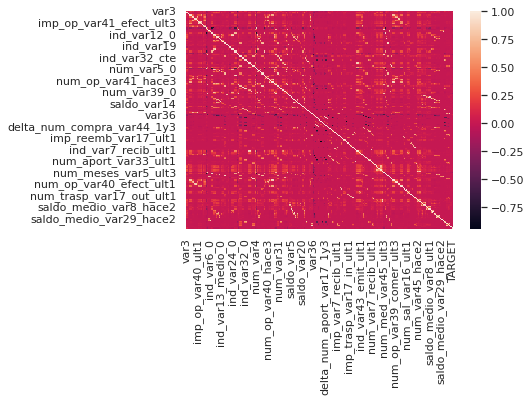

In [ ]:
#checking relation in data
sns.heatmap(df_train.corr())
plt.show()

In [ ]:
#selecting a few variables on which to run analysis

selected_variables = ["var3", "var15", "var38", 'saldo_medio_var5_ult3']

## Distribution plots

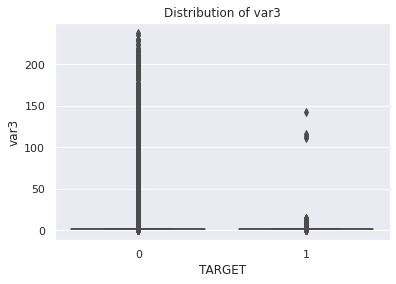

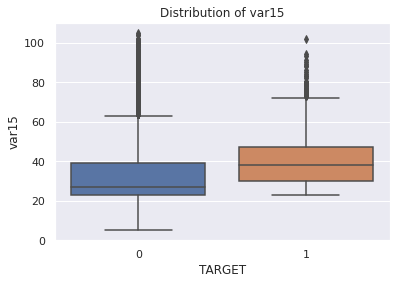

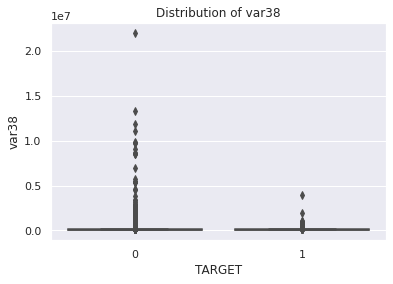

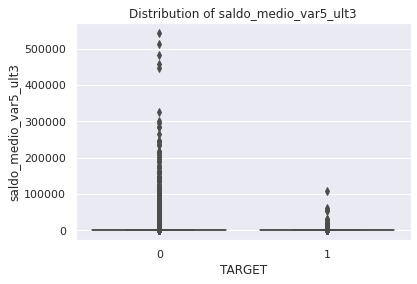

In [ ]:
for col in selected_variables:
  sns.boxplot(data=df_train, y=col, x="TARGET")
  plt.title(f"Distribution of {col}")
  plt.show()

For the variable "var3", it can be observed that the outliers are much dense in case of 0 target value than 1.

The distribution of "var15" is almost similar for the two target classes.

In case of both "var38" and "saldo_medio_var5_ult3" the distribution lies mostly in the outlier region.

Also the values of different continuous values range from 0 to 1e7, which is why scaling the data is ncessary.

## Histograms plots to check spread

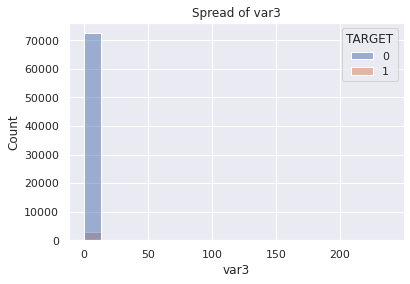

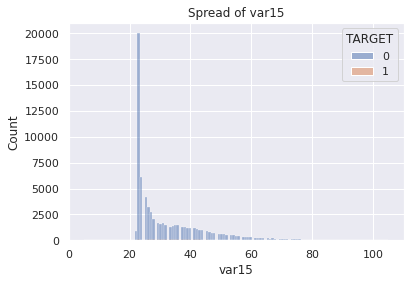

In [ ]:
for col in selected_variables[:2]:
  sns.histplot(data=df_train, x=col, hue="TARGET")
  plt.title(f"Spread of {col}")
  plt.show()

The var3 variables has dense state of values near to 0 while the var15 data points are distributed for a larger range.

## Relation among variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


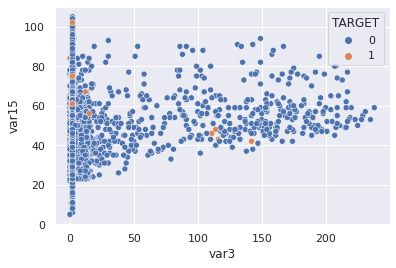

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


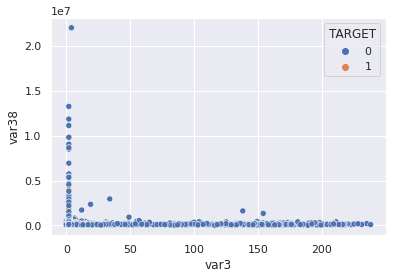

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


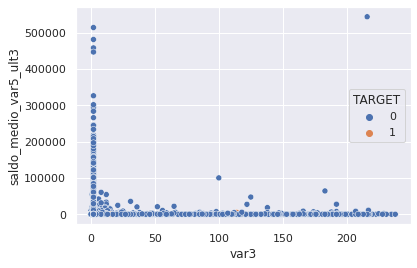

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


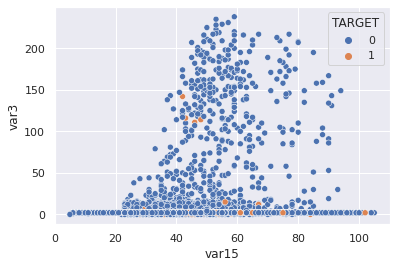

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


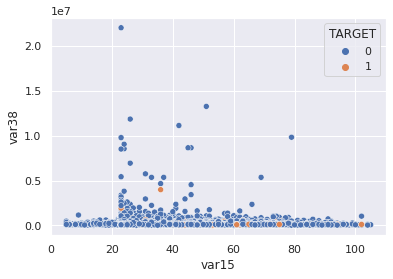

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


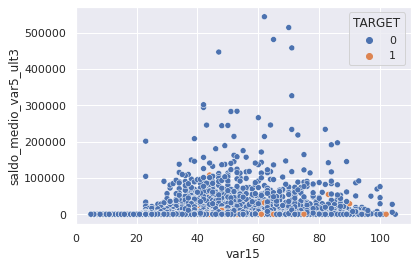

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


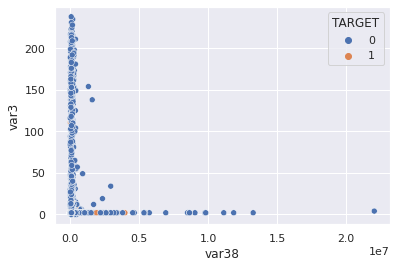

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


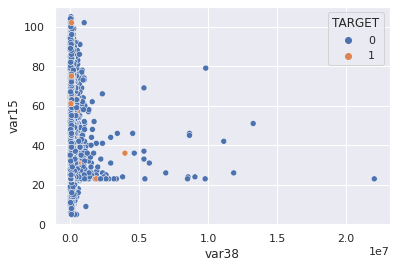

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


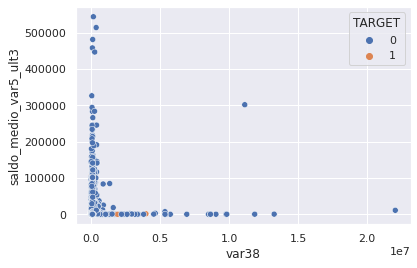

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


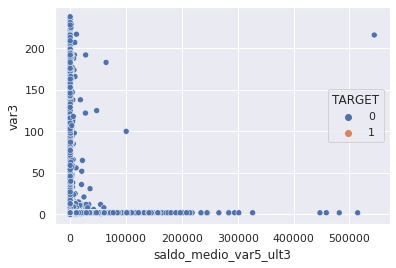

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


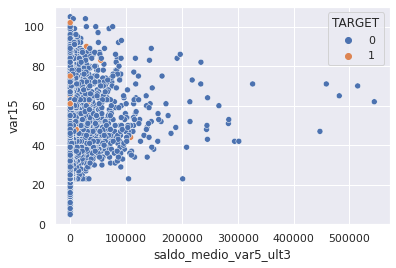

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


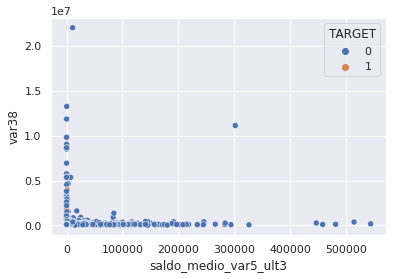

In [ ]:
for col in selected_variables:
  for second_col in selected_variables:
    if col != second_col:
      sns.scatterplot(df_train[col], df_train[second_col], hue=df_train["TARGET"])
      plt.xlabel(col)
      plt.ylabel(second_col)
      plt.show()

# Base Models

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


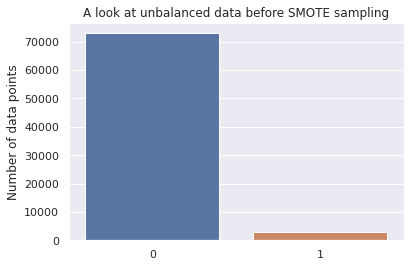

We have only 0.0396% rows with category label 1 in the response variable.


In [ ]:
#plot to visualize class imbalance

ax = sns.barplot(["0", "1"], [len(df_train[df_train['TARGET']==0]), len(df_train[df_train['TARGET']==1])])
ax.set(ylabel='Number of data points', title='A look at unbalanced data before SMOTE sampling')
plt.show()
num_1 = len(df_train[df_train['TARGET']==1])
num_0 = len(df_train[df_train['TARGET']==0])
perc_1 = num_1/(num_1 + num_0)
print(f'We have only {perc_1:.4f}% rows with category label 1 in the response variable.')

Comments / Observations:
1. The data is highly imbalanced with the dominant class being class 0 (customer satisfied) and this means that the accuracy of the model is not a good estimate of model performance if we use this data as is. 
2. To fix data imbalance, we will now use a technique which generates synthetic data for our minority class, and thereby creates a balanced dataset.

In [ ]:
#resampling data using SMOTE(Synthetic Minority Oversampling Technique) technique

method = SMOTE(sampling_strategy="minority")

x_train = df_train.drop('TARGET', axis=1)
y_train = df_train['TARGET']

x_train, y_train = method.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


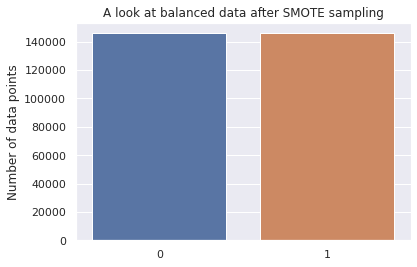

After SMOTE sampling, we now have 0.5000% rows with category label 1 in the response variable.


In [ ]:
#visualizing the effect of SMOTE resampling on data imbalance

ax = sns.barplot(["0", "1"], [len(y_train==0), len(y_train==1)])
ax.set(ylabel='Number of data points', title='A look at balanced data after SMOTE sampling')
plt.show()
num_1 = len(y_train==1)
num_0 = len(y_train==0)
perc_1 = num_1/(num_1 + num_0)

print(f'After SMOTE sampling, we now have {perc_1:.4f}% rows with category label 1 in the response variable.')

In [ ]:
#splitting data into training and test sets

x_train, x_val ,y_train, y_val = train_test_split(x_train, y_train , test_size=0.2,random_state=10)

In [ ]:
#checking the class balance in after splitting

print('No. of samples in class 1:',len(y_train[y_train==1]),'\tNo. of samples in class 0:',len(y_train[y_train==0]))

No. of samples in class 1: 58299 	No. of samples in class 0: 58520


Now, as we will be comparing all the models that we build, it is useful to have a function that can display model evaluation metrics in a common format.

In [ ]:
#function to evaluate models
def evaluate_model(model, predictor, response):
  
  y_pred_proba = model.predict_proba(predictor)
  y_prob = y_pred_proba[:,1]

  y_pred = model.predict(predictor)
  fpr, tpr, threshold = roc_curve(response, y_prob)

  model_name = type(model).__name__ #using a special method (dunder methods) to access class name
  print(f'{model_name}\n')
  plt.figure(figsize=(10,6))
  plt.plot(fpr, tpr, label='roc curve')
  plt.plot([0,1], [0,1], label='baseline')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f'{model_name}: roc curve')
  plt.legend(loc='lower right')
  plt.show()

  #computing model evaluation metrics
  auc_score = roc_auc_score(response, y_prob)
  precision = precision_score(response, y_pred)
  recall = recall_score(response, y_pred)
  accuracy = accuracy_score(response, y_pred)
  balanced_accuracy = balanced_accuracy_score(response, y_pred)
  f_score = f1_score(response, y_pred)
  
  #building a pretty table to output overall model metrics
  print('\nModel evaluation (overall):-')
  table = PrettyTable(['Metric', 'Score'])
  table.add_row(['roc_auc_score',round(auc_score,4)])
  table.add_row(['precision score', round(precision,4)])
  table.add_row(['recall', round(recall,4)])
  table.add_row(['accuracy',round(accuracy,4)])
  table.add_row(['balanced accuracy', round(balanced_accuracy,4)])
  table.add_row(['F1 score', round(f_score,4)])

  print(table)

  #generating model report using sklearn's classification_report module
  ##the report will contain class specific metrics
  report = classification_report(response, y_pred)
  
  #information to help with interpretation of metrics
  print('\n')
  print('=> Class-wise Model Evaluation: \n',report)
  print('Notes & References: \n1. The F1 score can be interpreted as a harmonic mean of the precision and recall, \nwhere an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]\
        \n2. The accuracy score is the accuracy, either the fraction of correct predictions.\
        \n3. ROC AUC score is the area under the roc curve.\
        \n4. Precision is the fraction of true positives over set of positive predictions. [tp / (tp + fp)]\
        \n5. Recall is the fraction of true positives over the set of actual condition positives. [tp / (tp + fn)]\
        \n6. The support is the number of occurrences of each class in y_true.\
        \n7. Macro accuracy calculates metrics for each label, and finds their unweighted mean. This does not take label imbalance into account.\
        \n8. Weighted accuracy calculates metrics for each label, and finds their average weighted by support')
  return auc_score, precision, recall, accuracy, balanced_accuracy, f_score, (fpr,tpr)

In [ ]:
#function to compute and display most important features using permutation importance method

def feat_importance(fit_model, scoring_criteria):
  
  #computing permutation importance for fit_model on scoring_criteria
  r = permutation_importance(fit_model, x_val, y_val, n_repeats=30, random_state=0, scoring=scoring_criteria)

  #building a pretty table to display important features computed above
  importance_pt = PrettyTable(['feature', 'importance (mean +/- std_dev)'])
  tot_dec = 0

  print('The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled.')

  imp_cols = []
  imp_means = []

  #storing important columns in a list
  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      tot_dec += r.importances_mean[i]
      imp_cols.append(x_val.columns[i])
      imp_means.append(r.importances_mean[i])
      importance_pt.add_row([f'{x_val.columns[i]:<8}', f'{r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}'])

  print(f'Estimate of total decrease in {scoring_criteria} when all the below mentioned features are removed: ~{round(tot_dec,4)}')
  print(importance_pt)
  return imp_cols, imp_means

### Feature selection - Permutation importance

In [ ]:
#feature selection using permutation importance

random_forest = RandomForestClassifier(n_estimators=100,max_depth=5)
random_forest.fit(x_train,y_train)

top_cols, means = feat_importance(random_forest, 'accuracy')

The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled.
Estimate of total decrease in accuracy when all the below mentioned features are removed: ~0.0442
+-------------------------+-------------------------------+
|         feature         | importance (mean +/- std_dev) |
+-------------------------+-------------------------------+
| imp_op_var41_efect_ult3 |        0.004 +/- 0.000        |
| imp_op_var39_comer_ult3 |        0.004 +/- 0.000        |
| imp_op_var39_comer_ult1 |        0.003 +/- 0.000        |
|         var15           |        0.003 +/- 0.000        |
|      num_var22_ult3     |        0.003 +/- 0.000        |
| imp_op_var41_efect_ult1 |        0.002 +/- 0.000        |
|    num_med_var22_ult3   |        0.002 +/- 0.000        |
|    imp_op_var41_ult1    |        0.002 +/- 0.000        |
|      num_var22_ult1     |        0.002 +/- 0.000        |
|     num_var45_hace3     |        0.002 +/- 0.000        |
|   

In [ ]:
x_train = x_train[top_cols]
x_val = x_val[top_cols]

df_test_copy = df_test[top_cols]

### Base model 1: Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression



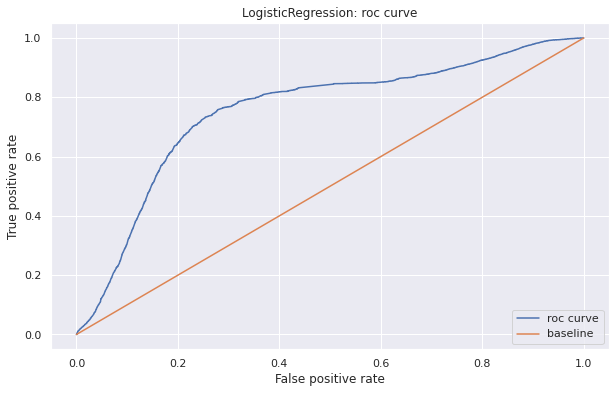


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.7539 |
|  precision score  | 0.5369 |
|       recall      | 0.9326 |
|      accuracy     | 0.5608 |
| balanced accuracy | 0.5579 |
|      F1 score     | 0.6815 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.73      0.18      0.29     14492
           1       0.54      0.93      0.68     14713

    accuracy                           0.56     29205
   macro avg       0.63      0.56      0.49     29205
weighted avg       0.63      0.56      0.49     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#building a logistic regression model with selected features

clist = [0.001, 0.1, 1, 10, 100, 1000, 100000]
cv_list = []

#hyperparameter tuning on parameter C
for c in clist:
  logreg = LogisticRegression(C = c)
  cval = cross_validate(logreg, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
  cv_list.append(np.mean(cval['test_score']))

#choosing the best parameter and building optimal model
best_c = clist[cv_list.index(max(cv_list))]
logreg_best = LogisticRegression(max_iter = 1000, C = best_c)
logreg_best.fit(x_train, y_train)

#model evaluation
auc_score_logreg, precision_logreg, recall_logreg, accuracy_logreg, balanced_accuracy_logreg, f_score_logreg, roc_logreg = evaluate_model(logreg_best, x_val, y_val)

### Base model 2: Decision Tree Classifier

DecisionTreeClassifier



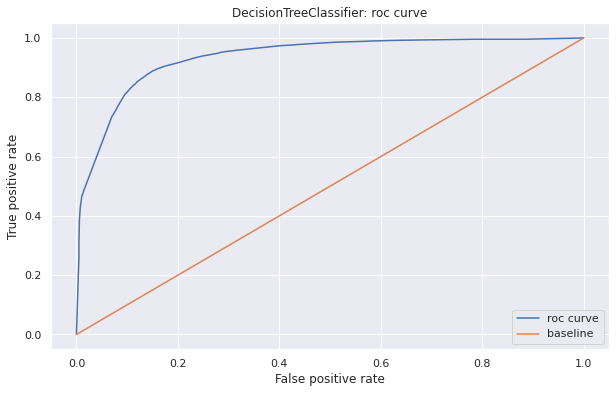


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.9353 |
|  precision score  | 0.8579 |
|       recall      | 0.8874 |
|      accuracy     | 0.8692 |
| balanced accuracy | 0.8691 |
|      F1 score     | 0.8724 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.88      0.85      0.87     14492
           1       0.86      0.89      0.87     14713

    accuracy                           0.87     29205
   macro avg       0.87      0.87      0.87     29205
weighted avg       0.87      0.87      0.87     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#buidling a decision tree model with selected features

depths = np.linspace(2, 12, 11)
cv_list = []

#hyperparameter tuning to get the best max_depth
for d in depths:
  dt = DecisionTreeClassifier(max_depth=d)
  cval = cross_validate(dt, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
  cv_list.append(np.mean(cval['test_score']))

#choosing the best max_depth and building optimal model
best_dt_d = depths[cv_list.index(max(cv_list))]
best_dt = DecisionTreeClassifier(max_depth=best_dt_d)
best_dt.fit(x_train, y_train)

#model evaluation
auc_score_dt, precision_dt, recall_dt, accuracy_dt, balanced_accuracy_dt, f_score_dt, roc_dt = evaluate_model(best_dt, x_val, y_val)

### Base model 3: k Nearest Neighbors Classifier

KNeighborsClassifier



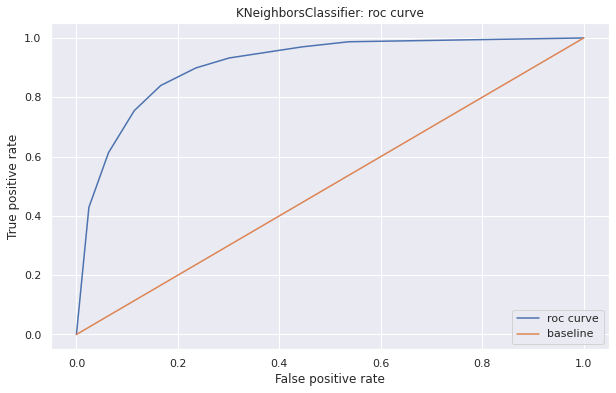


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.909  |
|  precision score  | 0.8368 |
|       recall      | 0.8397 |
|      accuracy     | 0.8368 |
| balanced accuracy | 0.8368 |
|      F1 score     | 0.8383 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     14492
           1       0.84      0.84      0.84     14713

    accuracy                           0.84     29205
   macro avg       0.84      0.84      0.84     29205
weighted avg       0.84      0.84      0.84     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#buidling a kNN classifier with selected features

klist = np.linspace(2,24,23)
cv_list = []

#hyperparameter tuning to get the best parameter k
for k in klist:
  knn = KNeighborsClassifier(n_neighbors = k)
  cval = cross_validate(dt, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
  cv_list.append(np.mean(cval['test_score']))

#choosing the best parameter k and buidling optimal model
best_k = klist[cv_list.index(max(cv_list))]
best_knn = KNeighborsClassifier(n_neighbors = int(best_k))
best_knn.fit(x_train, y_train)

#model evaluation
auc_score_knn, precision_knn, recall_knn, accuracy_knn, balanced_accuracy_knn, f_score_knn, roc_knn = evaluate_model(best_knn, x_val, y_val)

# Ensemble Models

### Ensemble model 1: Bagging Classifier

BaggingClassifier



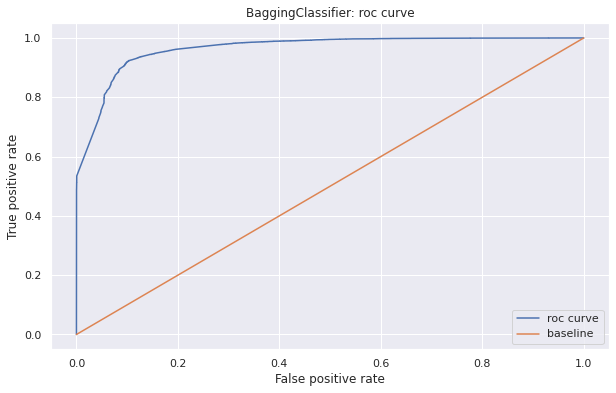


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.9639 |
|  precision score  | 0.9045 |
|       recall      | 0.9163 |
|      accuracy     | 0.9091 |
| balanced accuracy | 0.909  |
|      F1 score     | 0.9103 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     14492
           1       0.90      0.92      0.91     14713

    accuracy                           0.91     29205
   macro avg       0.91      0.91      0.91     29205
weighted avg       0.91      0.91      0.91     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#buidling a Bagging classifier with selected features

depths = np.linspace(2, 12, 11)
cv_list = []

#hyperparameter tuning to get the best max_depth
for d in depths:
  dt = DecisionTreeClassifier(max_depth=d)
  bg = BaggingClassifier(dt, random_state=10, n_estimators=50, bootstrap_features=True, oob_score=True)
  bg.fit(x_train, y_train)
  cv_list.append(bg.oob_score_)

#choosing the best max_depth and building optimal model
best_bg_d = depths[cv_list.index(max(cv_list))]
best_bg_dt = DecisionTreeClassifier(max_depth=best_bg_d)
bg_best = BaggingClassifier(best_bg_dt, random_state=10, n_estimators=50, bootstrap_features=True)
bg_best.fit(x_train, y_train)

#model evaluation
auc_score_bg, precision_bg, recall_bg, accuracy_bg, balanced_accuracy_bg, f_score_bg, roc_bg = evaluate_model(bg_best, x_val, y_val)

### Ensemble model 2: Random Forest Classifier

RandomForestClassifier



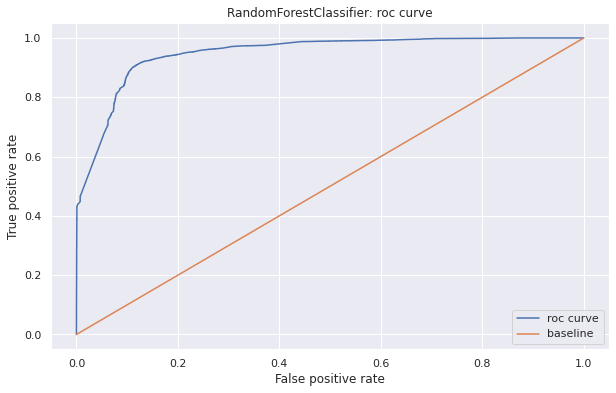


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.9483 |
|  precision score  | 0.8885 |
|       recall      | 0.9053 |
|      accuracy     | 0.8951 |
| balanced accuracy | 0.895  |
|      F1 score     | 0.8968 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     14492
           1       0.89      0.91      0.90     14713

    accuracy                           0.90     29205
   macro avg       0.90      0.89      0.90     29205
weighted avg       0.90      0.90      0.90     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#buidling a random forest classifier with selected features

depths = np.linspace(2, 12, 23)
cv_list = []

#hyperparameter tuning for the best max_depth
for d in depths:
  rf = RandomForestClassifier(max_depth=d, random_state=10, oob_score=True)
  rf.fit(x_train, y_train)
  cv_list.append(rf.oob_score_)

#choosing the best max_depth and buidling optimal model
best_rf_d = depths[cv_list.index(max(cv_list))]
rf_best = RandomForestClassifier(max_depth=best_rf_d, random_state=10)
rf_best.fit(x_train, y_train)

#model evaluation
auc_score_rf, precision_rf, recall_rf, accuracy_rf, balanced_accuracy_rf, f_score_rf, roc_rf = evaluate_model(rf_best, x_val, y_val)

### Ensemble model 3: Gradient Boosted Trees

GradientBoostingClassifier



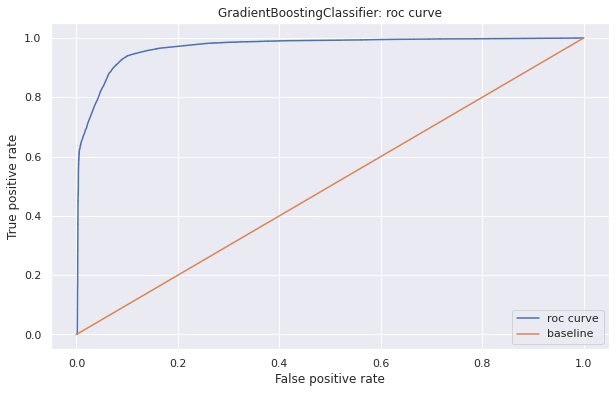


Model evaluation (overall):-
+-------------------+--------+
|       Metric      | Score  |
+-------------------+--------+
|   roc_auc_score   | 0.9692 |
|  precision score  | 0.9065 |
|       recall      | 0.9373 |
|      accuracy     | 0.9197 |
| balanced accuracy | 0.9195 |
|      F1 score     | 0.9216 |
+-------------------+--------+


=> Class-wise Model Evaluation: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92     14492
           1       0.91      0.94      0.92     14713

    accuracy                           0.92     29205
   macro avg       0.92      0.92      0.92     29205
weighted avg       0.92      0.92      0.92     29205

Notes & References: 
1. The F1 score can be interpreted as a harmonic mean of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. [2 * (precision * recall) / (precision + recall)]        
2. The accuracy score is the accuracy, either the fraction of corr

In [ ]:
#building a gradient boosted tree classifier with selected features

depths = np.linspace(2, 12, 11)
cv_list = []

#hyperparameter tuning to select the best max_depth
for d in depths:
  gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=d, random_state=10)
  cval = cross_validate(gb, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
  cv_list.append(np.mean(cval['test_score']))

#choosing the best max_depth and buidling an optimal model
best_gb_d = depths[cv_list.index(max(cv_list))]
gb_best = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=best_gb_d, random_state=10)
gb_best.fit(x_train, y_train)

#model evaluation
auc_score_gb, precision_gb, recall_gb, accuracy_gb, balanced_accuracy_gb, f_score_gb, roc_gb = evaluate_model(gb_best, x_val, y_val)

# Model Comparison

In [ ]:
#collating all model metrics 

models = [logreg_best, best_dt, best_knn, bg_best, rf_best, gb_best]
roc_list = [roc_logreg, roc_dt, roc_knn, roc_bg, roc_rf, roc_gb]
model_names = ['Logistic Regression', 'Decision Trees', 'kNN Classifier', 'Bagging Classifier', 'Random Forest Classifier', 'Gradient Boosted Trees']

auc_scores_list = [auc_score_logreg, auc_score_dt, auc_score_knn, auc_score_bg, auc_score_rf, auc_score_gb]
precision_list = [precision_logreg, precision_dt, precision_knn, precision_bg, precision_rf, precision_gb]
recall_list = [recall_logreg, recall_dt, recall_knn, recall_bg, recall_rf, recall_gb]
accuracy_list = [accuracy_logreg, accuracy_dt, accuracy_knn, accuracy_bg, accuracy_rf, accuracy_gb]
balanced_accuracy_list = [balanced_accuracy_logreg, balanced_accuracy_dt, balanced_accuracy_knn, balanced_accuracy_bg, balanced_accuracy_rf, balanced_accuracy_gb]
f1_score_list = [f_score_logreg, f_score_dt, f_score_knn, f_score_bg, f_score_rf, f_score_gb]

metrics = {'models': models, 'auc_score': auc_scores_list, 'precision': precision_list, 'recall': recall_list, 'accuracy': accuracy_list, 'balanced_accuracy': balanced_accuracy_list, 'f1_score': f1_score_list}

metrics_df = pd.DataFrame(list(zip(model_names, auc_scores_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, f1_score_list)), columns=['Model', 'auc score', 'precision', 'recall', 'accuracy', 'balanced_accuracy', 'f1 score'])

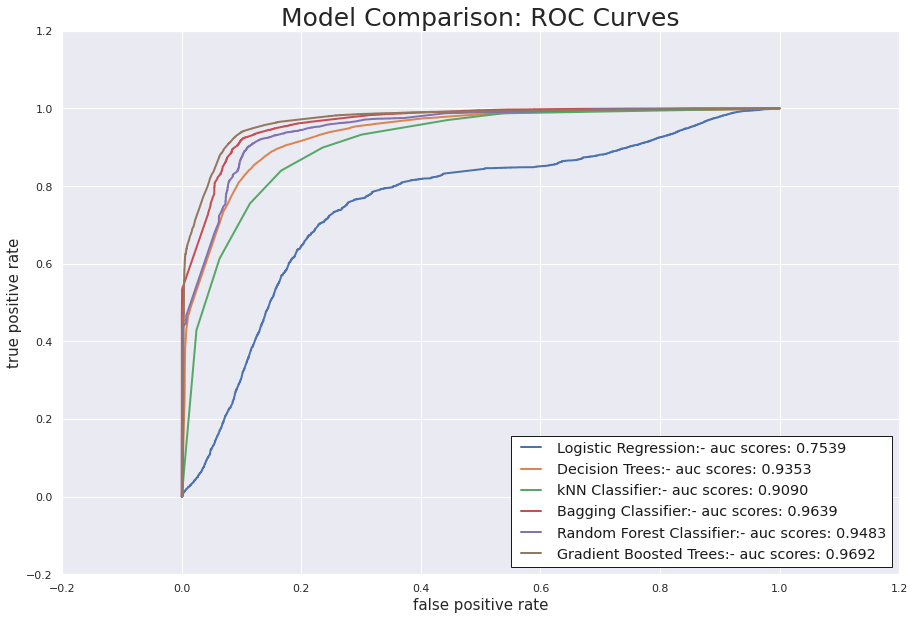

In [ ]:
#comparison of roc curves  
plt.figure(figsize=(15,10))

idx = 0

for roc in roc_list:
  plt.plot(roc[0], roc[1], label=f'{model_names[idx]}:- auc scores: {auc_scores_list[idx]:.4f}', linewidth=2)
  idx+=1

plt.style.use('classic')
plt.title('Model Comparison: ROC Curves', fontsize=25)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Model Comparison: AUC & F1 scores')

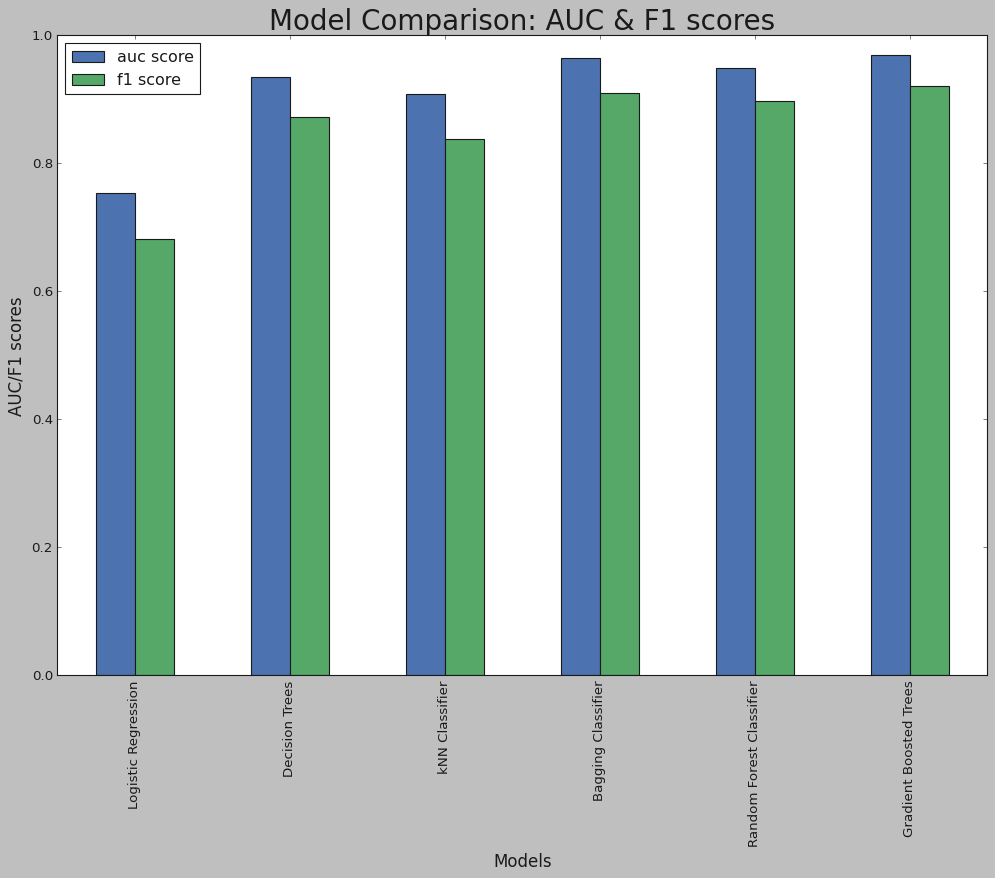

In [ ]:
#comparison of model metrics
#f1, roc

metrics_df.plot(x='Model', y=['auc score', 'f1 score'], kind='bar', stacked=False, figsize=(15,10))
plt.style.use('classic')
plt.xlabel('Models', fontsize=15)
plt.ylabel('AUC/F1 scores', fontsize=15)
plt.title('Model Comparison: AUC & F1 scores', fontsize=25)

# Model Interpretation

In [ ]:
#calculating the false postive rate for the best model
y_pred = gb_best.predict(x_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

false_positive_rate = fp/(fp+tn)
print('The best gradient boosted tree model has a false positive rate of',false_positive_rate)

0.09819210598951146

Below are the predictors sorted in the order of relative importance.

In [ ]:
#identifying the most important features of the best model

criteria = 'accuracy'
criteria_list = metrics[criteria]

best_model_idx = criteria_list.index(max(criteria_list))
best_model = models[best_model_idx]

top_cols, means = feat_importance(best_model, criteria)

The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled.
Estimate of total decrease in accuracy when all the below mentioned features are removed: ~0.6539
+-------------------------+-------------------------------+
|         feature         | importance (mean +/- std_dev) |
+-------------------------+-------------------------------+
|       saldo_var30       |        0.101 +/- 0.002        |
|         var15           |        0.073 +/- 0.002        |
|  saldo_medio_var5_hace3 |        0.053 +/- 0.001        |
|     num_var45_hace2     |        0.045 +/- 0.001        |
|     num_var45_hace3     |        0.040 +/- 0.001        |
|   imp_trans_var37_ult1  |        0.031 +/- 0.001        |
|   num_var43_recib_ult1  |        0.030 +/- 0.001        |
|    num_med_var45_ult3   |        0.027 +/- 0.001        |
|     num_var22_hace3     |        0.025 +/- 0.001        |
|      num_var45_ult1     |        0.023 +/- 0.001        |
|   

Text(0.5, 1.0, 'Top 10 Most Important Features: Best Model\n(Permutation Importance)')

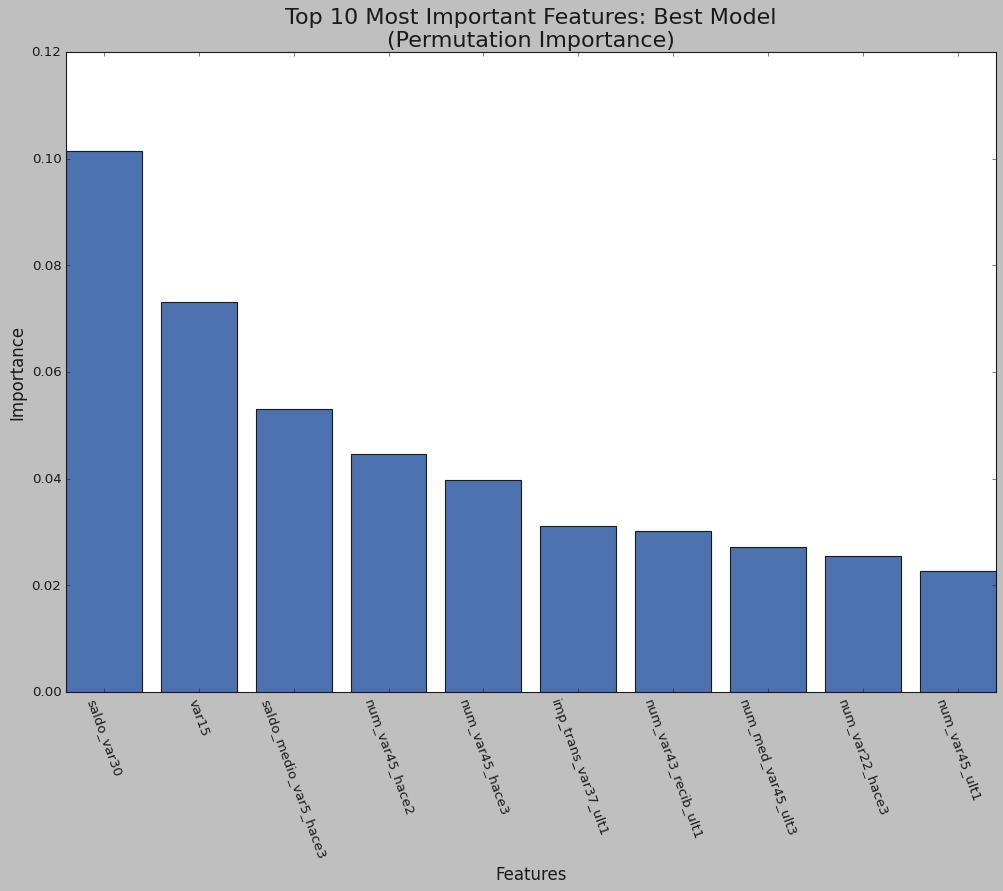

In [ ]:
#comparison of model metrics
plt.figure(figsize=(15,10))
plt.bar(top_cols[:10], means[:10])
plt.style.use('classic')
plt.xticks(rotation = -70)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Top 10 Most Important Features: Best Model\n(Permutation Importance)', fontsize=20)

# Model Predictions

In [ ]:
#generating model predictions into csv files

test_set = pd.read_csv('test.csv')
id = pd.DataFrame(test_set['ID'])

for model in models:
  model_name = type(model).__name__
  ytest_pred = model.predict(df_test_copy)  
  id['TARGET'] = ytest_pred
  id.to_csv(f'submission_{model_name}.csv', index=False)

# Conclusions
1. The Gradient Boosting ensemble model is giving the best results with a recall (true positive rate - customer dissatisfaction rate) of 95.27% and roc auc score of 0.98 on the validation set. 

2. The F1 score is 0.95 which implies that the model predicts well on both classes and has a great balance of predicting both the satisfied & dissatisfied customers accurately.

3. The false positive rate (9.8%) is quite low indicating that there will be very little misallocation of resources on customers wrongly classified as dissatisfied.

4. Applying permutation importance on the best model identified the features that are most important for prediction. Santander Bank Ltd can use these and focus more on strong areas & improve weaker areas.

5. A root cause analysis could then help identify causal factors behind the high impact predictors of customer satisfaction and help bring out best practices to improve customer satisfaction.

6. There's still room for better feature engineering, but as the features are anonymized we cannot use domain knowledge to build better features. Perhaps, statistical methods like factor analysis could be avenues to explore in this direction. Furthermore, feature selection like SHAP and LIME can explored as well.


# References
1. Gilbert A. Churchill, JR., and Carol Suprenant, (November 1982). An Investigation Into the Determinants of Customer Satisfaction. Journal of Marketing Research Vol. XIX , 491-504. https://doi.org/10.1177%2F002224378201900410
2. https://asq.org/quality-resources/customer-satisfaction